In [131]:
# Load the data and libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from numba import njit

# Load data files
import numpy as np
import urllib.request
import io

url_x = 'https://github.com/jnear/cs211-data-privacy/raw/master/slides/adult_processed_x.npy'
url_y = 'https://github.com/jnear/cs211-data-privacy/raw/master/slides/adult_processed_y.npy'

with urllib.request.urlopen(url_x) as url:
    f = io.BytesIO(url.read())
X = np.load(f)

with urllib.request.urlopen(url_y) as url:
    f = io.BytesIO(url.read())
y = np.load(f)

In [91]:
def gaussian_mech_vec(vec, sensitivity, epsilon, delta):
    return vec + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon, size=vec.shape)

In [92]:
def gaussian_mech_zCDP_vec(vec, sensitivity, rho):
    sigma = np.sqrt((sensitivity**2) / (2 * rho))
    return vec + np.random.normal(loc=0, scale=sigma, size=vec.shape)

In [520]:
# Split data into training and test sets
training_size = int(X.shape[0] * 0.8)

X_train = X[:training_size]
X_test = X[training_size:]

y_train = y[:training_size]
y_test = y[training_size:]

print('Train and test set sizes:', len(y_train), len(y_test))

Train and test set sizes: 36176 9044


# Clipping and Gradient definition

In [94]:
def L2_clip_array(vs , b):
    norms = np.linalg.norm(vs, ord = 2, axis = 1)
    ratios = vs/norms[:, None]
    results = np.where((norms > b)[:, None], b*ratios, vs)
    return results

In [95]:
def vgradient(theta_in, x_in, y_in, C):
    x = x_in
    y = y_in
    theta = theta_in
    exponent = y * np.dot(x, theta)
    rhs = (y/(1+np.exp(exponent)))
    gradients = -(x*rhs[:, None])
    clipped_grads = L2_clip_array(gradients, C)
    return np.sum(clipped_grads, axis = 0)

In [96]:
# Prediction: take a model (theta) and a single example (xi) and return its predicted label
def predict(xi, theta, bias=0):
    label = np.sign(xi @ theta + bias)
    return label

def accuracy(theta):
    return np.sum(predict(X_test, theta) == y_test)/X_test.shape[0]

In [97]:
def dp_gradient_descent(iterations, alpha, epsilon):
    eps_i = epsilon/iterations
    theta = np.zeros(X_train.shape[1])  # leaks the number of features, without privacy
    clipping_param = 5
    num_examples = X_train.shape[0]     # leaks the number of training examples, without privacy
    for i in range(iterations):
        grad_sum        = vgradient(theta, X_train, y_train, clipping_param)
        noisy_grad_sum  = gaussian_mech_vec(grad_sum, clipping_param, 1, 1e-5)
        noisy_avg_grad  = noisy_grad_sum / num_examples
        theta           = theta - noisy_avg_grad

    return theta

# Baseline (gradient clipping DP-SGD)

In [98]:
def gaussian_mech_RDP_vec(vec, sensitivity, alpha, epsilon):
    sigma = np.sqrt((sensitivity**2 * alpha) / (2 * epsilon))
    return vec + np.random.normal(loc=0, scale=sigma, size=vec.shape)

In [163]:
def dp_gradient_descent(epochs, rho):
    rho_i = rho/epochs
    theta = np.zeros(X_train.shape[1])  # leaks the number of features, without privacy
    clipping_param = 1
    num_examples = X_train.shape[0]     # leaks the number of training examples, without privacy

    BATCH_SIZE = 256
    num_batches = int(num_examples / BATCH_SIZE)
    batches_X = np.array_split(X, num_batches)
    batches_y = np.array_split(y, num_batches)

    for i in range(epochs):

        for xs, ys in zip(batches_X, batches_y):
            grad_sum        = vgradient(theta, xs, ys, clipping_param)
            noisy_grad_sum  = gaussian_mech_zCDP_vec(grad_sum, clipping_param, rho_i)
            noisy_avg_grad  = noisy_grad_sum / BATCH_SIZE
            theta           = theta - noisy_avg_grad

    return theta

In [100]:
def get_eps(epsilon, alpha, delta):
    ed_eps = epsilon + np.log(1/delta)/(alpha - 1)
    print(f'Total epsilon = {ed_eps}, delta = {delta}')
    return ed_eps

In [101]:
get_eps(.01, 500, 1e-5)

Total epsilon = 0.033071994919780016, delta = 1e-05


0.033071994919780016

In [133]:
@njit()
def zcdp_eps(rho, delta):
    return rho + 2*np.sqrt(rho * np.log(1/delta))
zcdp_eps(0.001, 1e-5)

0.21559660262893474

In [103]:
rho = .001
epochs = 5
print('eps:', zcdp_eps(rho, 1e-5))
accs = [accuracy(dp_gradient_descent(epochs, rho)) for _ in range(10)]
print('mean:', np.mean(accs))
print('std:', np.std(accs))

eps: 0.21559660262893474
mean: 0.7586134453781512
std: 0.012517000702642996


# Smooth Sensitivity Trimmed Mean

In [462]:
@njit()
def get_with_default(values, indexes, lower, upper):
    vals = np.zeros(len(values) + 2, dtype=np.float64)
    vals[0] = lower
    vals[-1] = upper
    vals[1:-1] = values
    idxes = np.maximum(np.minimum(indexes, len(values)), -1) + 1
    idxes = idxes % len(values)
    return values[idxes]

In [191]:
def build_indices(n, m, k_range):
    lhs_indices = []
    rhs_indices = []
    for k in range(0, k_range):
        lhs_indices.append(np.array([n-m+1+k-l for l in range(0, k+2)]))
        rhs_indices.append(np.array([m+1-l for l in range(0, k+2)]))
    return (lhs_indices, rhs_indices)

In [192]:
n = 20
m = 2
a = 0
b = 10
lhs_indices, rhs_indices = build_indices(n, m, 128)

In [491]:
@njit()
def compute_sens(xs, t, n, m, a, b):
    sorted_xs = np.sort(xs)

    # calculate the smooth sensitivity
    num_senses = 5
    scaled_sensitivity_at_distances = np.zeros(num_senses)

    #for k in range(0, n+1):
    for k in range(0, num_senses): # TODO: loop over k (but this is slow)
        scaling = np.exp(- k * t)
        
        lhs_i = np.array([n-m+1+k-l for l in range(0, k+2)])
        rhs_i = np.array([m+1-l for l in range(0, k+2)])
        lhs = get_with_default(sorted_xs, lhs_i, a, b)
        rhs = get_with_default(sorted_xs, rhs_i, a, b)
        inner = np.abs(lhs - rhs)
        #print('new inner:', new_inner)
        #print('indices:', lhs_indices)
        #inner = np.array([abs(get(n-m+1+k-l) - get(m+1-l)) for l in range(0, k+2)])
        #print('inner:', inner)
        inner_max = np.max(inner)
        scaled_inner = scaling * inner_max
        if scaled_inner > 1e30:
            print(scaled_inner, inner_max, scaling, lhs, rhs)
        #print('k:', k, 'scaled sens:', scaled_inner)
        scaled_sensitivity_at_distances[k] = scaled_inner

    return (1/(n - 2*m)) * np.max(scaled_sensitivity_at_distances)

### Smooth gaussian sens

In [528]:
#@njit()
def smooth_gaussian_noise(vec, sens, eps, delta=1e-5):
    alpha = eps/(5*np.sqrt(np.log(2/delta)))
    
    d  = len(vec)
    nv = np.random.normal(size=d)
    # unsure if this multiplication is right. It makes the results dope
    hz = nv #*(2*np.pi)**(-(d/2 - 1))
    return vec + hz*sens/alpha

@njit()
def gaussian_beta(d, eps, delta=1e-5):
    return eps/(4*(d + np.log(2/delta)))

#@njit()
def compute_gauss_senses(xs, m, a, b, eps, delta=1e-5):
    clipped_xs = xs.clip(a, b)
    n = len(clipped_xs)
    
    t = gaussian_beta(len(xs), eps, delta)
    sens = compute_sens(clipped_xs, t, n, m, a, b)
    return np.mean(clipped_xs), sens
    

In [492]:
eps = .01
delta=1e-5
test_array = np.random.normal(loc=5, scale=1, size=20).clip(a, b)
t = gaussian_beta(len(test_array), eps, delta)
compute_sens(test_array, t, n, m, a, b)

0.0176637008478168

In [493]:
t = .01
#test_array = np.random.normal(loc=5, scale=1, size=20).clip(a, b)
compute_sens(test_array, t, n, m, a, b)

0.0176637008478168

In [494]:
a = 0
b = 10
t = 5

m = 10
n = 104
lhs_indices, rhs_indices = build_indices(n, m, 100)

def test_sens(t):
    test_array = np.random.normal(loc=5, scale=1, size=104).clip(a, b)
    n = len(test_array)
    #lhs_indices, rhs_indices = build_indices(n, m, 3)
    return compute_sens(test_array, t, n, m, a, b)

In [169]:
10/104

0.09615384615384616

In [496]:
%%time
ts = np.linspace(0.0001, 0.1, 100)
results = [np.mean([test_sens(t) for _ in range(50)]) for t in ts]

CPU times: user 203 ms, sys: 3.37 ms, total: 206 ms
Wall time: 204 ms


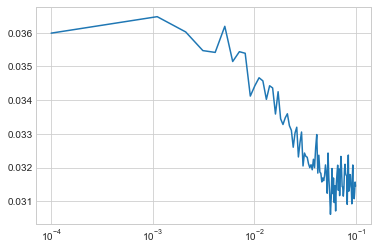

In [497]:
plt.plot(ts,results)
plt.xscale('log');

# Smooth Sensitivity DP-SGD

In [526]:
def vgradient_per_ex(theta_in, x_in, y_in):
    x = x_in
    y = y_in
    theta = theta_in
    exponent = y * np.dot(x, theta)
    rhs = (y/(1+np.exp(exponent)))
    gradients = -(x*rhs[:, None])
    return gradients

def smooth_dp_gradient_descent(epochs, rho):
    rho_i = rho/epochs
    theta = np.zeros(X_train.shape[1])  # leaks the number of features, without privacy
    clipping_param = 1
    num_examples = X_train.shape[0]     # leaks the number of training examples, without privacy

    upper = 1
    lower = -1
    m = 100
    #t = 80

    #alpha = 100
    t = .01
    
    BATCH_SIZE = 256
    lhs_indices, rhs_indices = build_indices(BATCH_SIZE, m, BATCH_SIZE)
    
    rho_weight = rho_i / X_train.shape[1]
    print('target per-weight rho:', rho_weight)
    target_eps_weight = np.sqrt(2*rho_weight)
    sigma = opt_sigma(target_eps_weight, t)
    #sigma = 1
    s = np.exp(-(3/2) * sigma**2) * (target_eps_weight - (t / sigma))
    print('sigma:', sigma, 's:', s)
    #1/0

    #assert 1/(1-np.exp(-t)) > alpha
    #gamma = alpha*(np.exp(t) - 1) + 1
    #print('gamma:', gamma)
    #epsilon = rho
    #epsilon_epoch = epsilon / epochs
    #epsilon_iter = epsilon_epoch / X_train.shape[1]
    #print('epsilon per weight:', epsilon_iter)

    def compute_eps(sens, alpha, t, sigma_sq):
        alpha_upper_bound = 1/(1-np.exp(-t))
        if alpha >= alpha_upper_bound:
            raise RuntimeError('alpha too high!!! t:', t, 'alpha:', alpha, 'req alpha <', 1/(1-np.exp(-t)))
        gamma = 1 - alpha*(1-np.exp(-t))
        return alpha * ((sens**2 / (2*gamma*sigma_sq)) + (t**2 / (4*gamma**2)))

    def compute_sigma_sq(sens):
        gamma = 1 - alpha*(1-np.exp(-t))
        #print('gamma:', gamma)

        top = (alpha * (sens**2))
        bottom_lhs = (2 * gamma * epsilon_iter)
        bottom_rhs = ((alpha * t**2) / (2 * gamma))
        #print('bottom lhs:', bottom_lhs)
        #print('bottom rhs:', bottom_rhs)
        return (top / (bottom_lhs - bottom_rhs))

    def spec_trimmed_mean(xs):
        return trimmed_mean(xs, t, m, lower, upper, lhs_indices, rhs_indices, compute_sigma_sq, sigma, s)
    
    
    num_batches = int(num_examples / BATCH_SIZE)
    batches_X = np.array_split(X, num_batches)
    batches_y = np.array_split(y, num_batches)
    
    #spec_trimmed_mean = lambda xs: trimmed_mean(xs, t, m, a, b, lhs_indices, rhs_indices, sigma, s)

    for i in range(epochs):

        for xs, ys in zip(batches_X, batches_y):
            gradients       = vgradient_per_ex(theta, xs, ys)
            noisy_avg_grad  = np.apply_along_axis(spec_trimmed_mean, 0, gradients)
            theta           = theta - noisy_avg_grad

    return theta


def smooth_gaussian_dp_gradient_descent(epochs, rho):
    rho_i = rho/epochs
    theta = np.zeros(X_train.shape[1])  # leaks the number of features, without privacy
    clipping_param = 1
    num_examples = X_train.shape[0]     # leaks the number of training examples, without privacy
    
    delta = 1e-5
    
    eps_i = zcdp_eps(rho_i, delta)

    upper = 1
    lower = -1
    m = 100
    #t = 80

    #alpha = 100
    t = .01
    
    BATCH_SIZE = 256
    lhs_indices, rhs_indices = build_indices(BATCH_SIZE, m, BATCH_SIZE)
    
    

    def sens_calc(xs):
        return compute_gauss_senses(xs, m, lower, upper, eps_i, delta)
    
    
    num_batches = int(num_examples / BATCH_SIZE)
    batches_X = np.array_split(X, num_batches)
    batches_y = np.array_split(y, num_batches)
    
    #spec_trimmed_mean = lambda xs: trimmed_mean(xs, t, m, a, b, lhs_indices, rhs_indices, sigma, s)

    for i in range(epochs):

        for xs, ys in zip(batches_X, batches_y):
            gradients       = vgradient_per_ex(theta, xs, ys)
            tm, senses      = np.apply_along_axis(sens_calc, 0, gradients)
            total_sens      = np.linalg.norm(senses)
            noisy_avg_grad  = smooth_gaussian_noise(tm, total_sens, eps_i, delta)
            theta           = theta - noisy_avg_grad

    return theta

In [516]:
def opt_exp(eps, t, sigma):
    return 5 * (eps / t) * sigma**3 - 5 * sigma**2 - 1

def opt_sigma(target_eps, t):
    sigma_lower = t / target_eps
    sigma_upper = max(2*t / target_eps, 1/2)
    
    loss = opt_exp(target_eps, t, np.mean([sigma_lower, sigma_upper]))
    while np.abs(loss) > 0.001:
        #print('loss:', loss)
        if loss < 0:
            sigma_lower = np.mean([sigma_lower, sigma_upper])
        else:
            sigma_upper = np.mean([sigma_lower, sigma_upper])

        loss = opt_exp(target_eps, t, np.mean([sigma_lower, sigma_upper]))

    return np.mean([sigma_lower, sigma_upper])

def trimmed_mean(xs, t, m, a, b, lhs_indices, rhs_indices, compute_sigma_sq, lln_sigma, s):
    clipped_xs = xs.clip(a, b)
    n = len(clipped_xs)
    #print('actual mean', np.mean(xs))
    sens = compute_sens(clipped_xs, t, n, m, a, b, lhs_indices, rhs_indices)
    noise = one_lln(lln_sigma)
    #print('scaling:', sens/s)
    return np.mean(clipped_xs) + (sens/s)*noise
    #print('sens:', sens)
    #sigma_sq = compute_sigma_sq(sens)
    #print('sigma_sq:', sigma_sq)
    #print(sigma_sq)
    # return np.mean(xs) + np.random.normal(loc=0, scale=np.sqrt(sigma_sq))
    
    #rho = (t**2/sigma**2) + (np.exp(3*sigma**2)*s**2)
    #print('actual rho:', rho)
    #print('noise scale:', (sens / s))
    return np.mean(xs)


    
    
    
    

In [527]:
accuracy(smooth_gaussian_dp_gradient_descent(1, .001))

0.010401609844141534
0.005081720477223145
0.00413137801015278
0.004304122995529389
0.0034987009976430337
0.003610840846589972
0.003309020994027781
0.003294600934787414
0.007133159400216091
0.0038345714549512955
0.002971387081685827
0.0030036086295448547
0.004529648201983705
0.0021128918606528714
0.0023666866853531174
0.0028962032227053225
0.0025398564419781893
0.0023281592728201296
0.002900409731303801
0.0019098902125592439
0.0024624682830733146
0.0027159016681987335
0.0021898412004317854
0.002019092924460956
0.0024012312061913255
0.002024978808972626
0.0020508883123008395
0.001777689716191981
0.0025630553549119274
0.0020383292380428664
0.0022424053374551505
0.0019448986539966622
0.001959583551372252
0.002450263217183588
0.001852026345254764
0.002117745641188883
0.002264695999998907
0.002014333059626626
0.002341880955459582
0.0019138262708738685
0.0022533456205967796
0.0026441526164620423
0.0022126261791611795
0.0017925943098247071
0.0032903678956398667
0.002113608583160019
0.001502247

0.8240822644847413

In [46]:
zcdp_eps(0.001, 1e-5)

0.21559660262893474

# Ours Experiments

In [124]:
our_means = means[3:]
our_stds = stds[3:]

NameError: name 'means' is not defined

In [519]:
rhos = [0.01, 0.001, 0.0001,.00001,.0000001]
our_epsilons = [zcdp_eps(rho, 1e-5) for rho in rhos]

our_means = []
our_stds = []
for rho in rhos:
    accs = []
    for _ in range(3):
        accs.append(accuracy(smooth_gaussian_dp_gradient_descent(5, rho)))
        print(accs[-1])
    our_means.append(np.mean(accs))
    our_stds.append(np.std(accs))
    print(np.mean(accs))

0.8296107916850951
0.8296107916850951
0.8296107916850951
0.8296107916850951
0.8296107916850951
0.8296107916850951
0.8296107916850951
0.8296107916850951
0.8296107916850951
0.8296107916850951
0.8296107916850951
0.8296107916850951
0.8296107916850951
0.8296107916850951
0.8296107916850951
0.8296107916850951
0.8296107916850951
0.8296107916850951
0.8296107916850951
0.8296107916850951


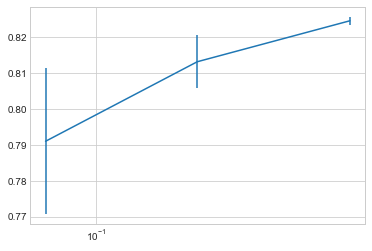

In [414]:
plt.errorbar(our_epsilons, our_means, yerr=our_stds)
plt.xscale('log')

# Experiments Baseline

In [415]:
rho = .001
epochs = 5
print('eps:', zcdp_eps(rho, 1e-5))
accs = [accuracy(dp_gradient_descent(epochs, rho)) for _ in range(10)]
print('mean:', np.mean(accs))
print('std:', np.std(accs))

eps: 0.21559660262893474
mean: 0.760515258735073
std: 0.014456729703378076


In [416]:
rhos = [0.1, 0.01, 0.001, 0.0001]
baseline_epsilons = [zcdp_eps(rho, 1e-5) for rho in rhos]
baseline_means = []
baseline_stds = []
for rho in rhos:
    accs = []
    for _ in range(3):
        accs.append(accuracy(dp_gradient_descent(5, rho)))
        print(accs[-1])
    baseline_means.append(np.mean(accs))
    baseline_stds.append(np.std(accs))  


0.8254091110128262
0.8246351172047767
0.8252985404688191
0.8087129588677576
0.8099292348518354
0.8104820875718709
0.7167182662538699
0.7603936311366651
0.7710084033613446
0.671937195931004
0.7119637328615657
0.732640424590889


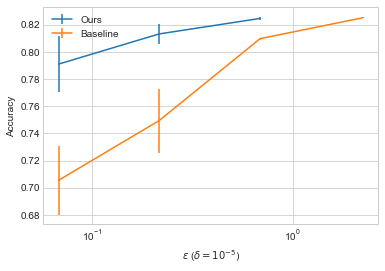

In [418]:
plt.errorbar(our_epsilons, our_means, yerr=our_stds, label='Ours')
plt.errorbar(baseline_epsilons, baseline_means, yerr=baseline_stds, label='Baseline')
plt.xscale('log')
plt.xlabel('$\epsilon$ ($\delta=10^{-5}$)')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
[(eps, acc) for eps, acc in zip(baseline_epsilons, baseline_means)]

# Laplace Log Normal

In [30]:
def one_lln(sigma):
    x = np.random.laplace()
    y = np.random.normal()
    return x * np.exp(sigma * y)

In [31]:
def lln(size):
    sigma = 1
    x = np.random.laplace(size=size)
    y = np.random.normal(size=size)
    return x * np.exp(sigma * y)

In [32]:
np.mean(lln(500000))

-0.0022373986857509285